In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/scratch/msc24h18/msc_project/aihwkit/src/')

plt.style.use('ggplot')

sys.path

['/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python311.zip',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11/lib-dynload',
 '',
 '/home/msc24h18/.local/lib/python3.11/site-packages',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11/site-packages',
 '/scratch/msc24h18/msc_project/src',
 '/scratch/msc24h18/msc_project/aihwkit/src/']

In [3]:
WORKING_DIR = '/scratch/msc24h18/msc_project'
FILE_PATH = 'data/LBE247_analyzed_2nd_run_only/LBE247_ID294YR/pulsedAmplitudeSweep_DCIV_20240919110921/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(2)]20240919111221/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(2)]20240919111221_Summary.dat'

data = pd.read_csv(os.path.join(WORKING_DIR, FILE_PATH), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,4,0.4,7.074337e+07,7.946788e+07
1,2,5,0.5,7.138472e+07,8.032838e+07
2,3,6,0.6,7.254367e+07,8.176013e+07
3,4,7,0.7,7.385688e+07,8.343206e+07
4,5,8,0.8,7.603927e+07,8.610224e+07


Number of LTP pulses: 15
Number of LTD pulses: 27


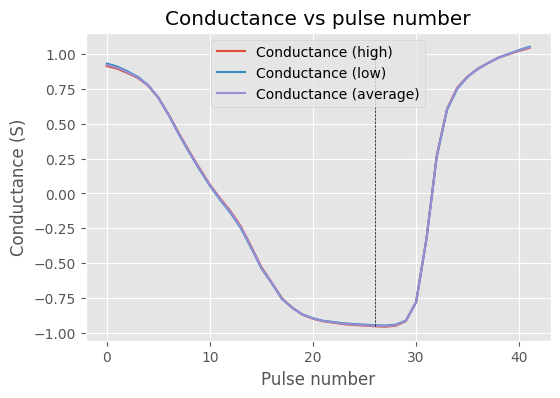

In [4]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2


def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())


conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

# ltp pulses are expected to be positive for fitting to work
pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']])
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

In [5]:
from aihwkit.utils.fitting import fit_measurements


def fit_model(device_config):
    params = {'dw_min': (0.1, 0.001, 1.0),
              'up_down': (0.0, -0.99, 0.99),
              'w_max': (1.0, 0.1, 2.0),
              'w_min': (-1.0, -2.0, -0.1),
              }

    result, device_config_fit, best_model_fit = fit_measurements(
        params,
        pulses,
        conductance,
        device_config)

    print(device_config_fit)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(conductance, label='Measured')
    ax.plot(best_model_fit, label='Fit')
    ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
    ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title=str(device_config))
    ax.legend()
    plt.show()

    # return result, device_config_fit, best_model_fit

ConstantStepDevice(
    dw_min=0.2363510307514418,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.6159287417115216,
    up_down_dtod=0.0,
    w_max=0.9795043012071296,
    w_max_dtod=0.0,
    w_min=-1.0473029028082665,
    w_min_dtod=0.0
)


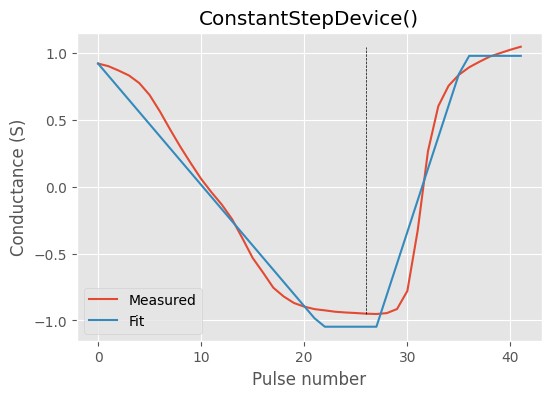

ExpStepDevice(
    dw_min=0.2468717761334231,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.6286256251849758,
    up_down_dtod=0.0,
    w_max=0.9784866728227765,
    w_max_dtod=0.0,
    w_min=-1.0911916563082174,
    w_min_dtod=0.0
)


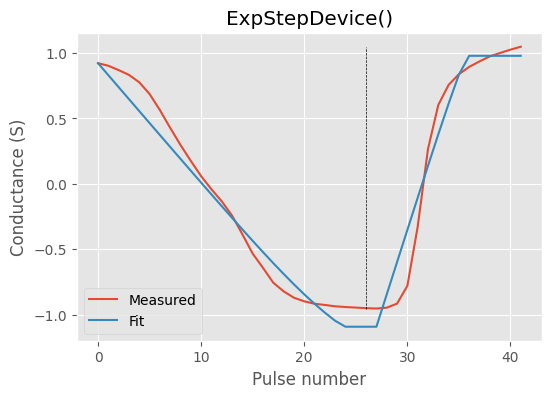

LinearStepDevice(
    dw_min=0.2363510307514418,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.6159287417115216,
    up_down_dtod=0.0,
    w_max=0.9795043012071296,
    w_max_dtod=0.0,
    w_min=-1.0473029028082665,
    w_min_dtod=0.0,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0
)


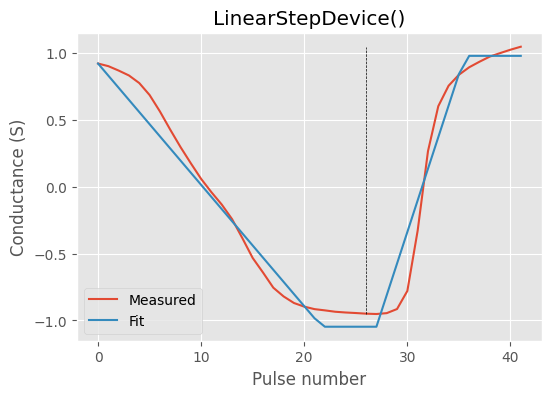

PowStepDevice(
    dw_min=0.38513838941228073,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.5754938742391738,
    up_down_dtod=0.0,
    w_max=1.9345913238773809,
    w_max_dtod=0.0,
    w_min=-1.9999942671483577,
    w_min_dtod=0.0,
    pow_gamma_dtod=0.0
)


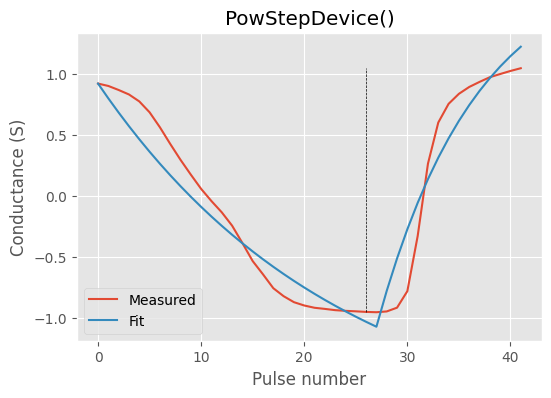

SoftBoundsDevice(
    dw_min=0.18932054682569144,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.5605549831139831,
    up_down_dtod=0.0,
    w_max=1.976155098044456,
    w_max_dtod=0.0,
    w_min=-1.9999888712259044,
    w_min_dtod=0.0
)


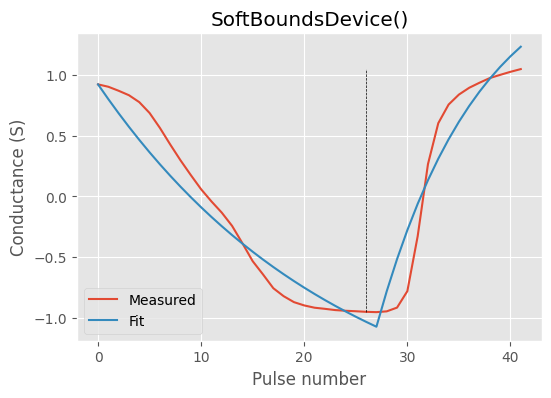

In [6]:
from aihwkit.simulator.configs import (
    ConstantStepDevice,
    ExpStepDevice,
    LinearStepDevice,
    PowStepDevice,
    SoftBoundsDevice
)

fit_model(ConstantStepDevice())
fit_model(ExpStepDevice())
fit_model(LinearStepDevice())
fit_model(PowStepDevice())
fit_model(SoftBoundsDevice())

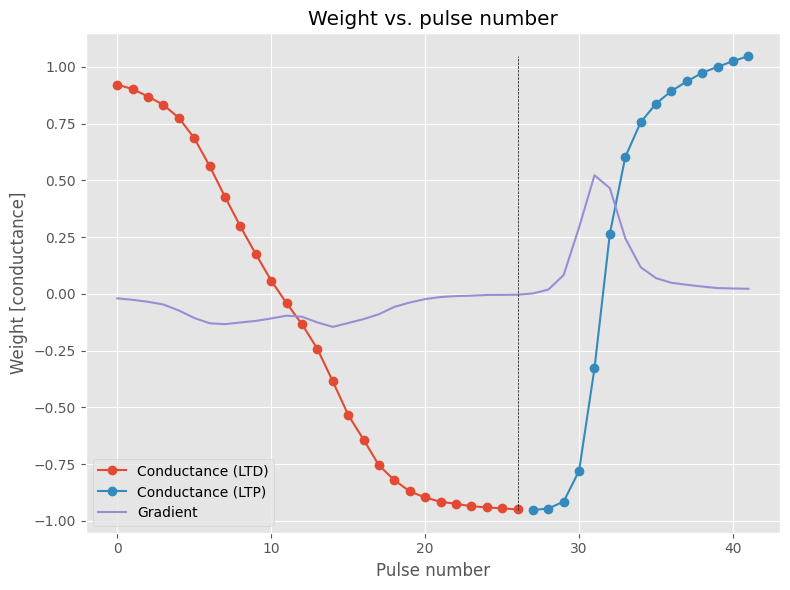

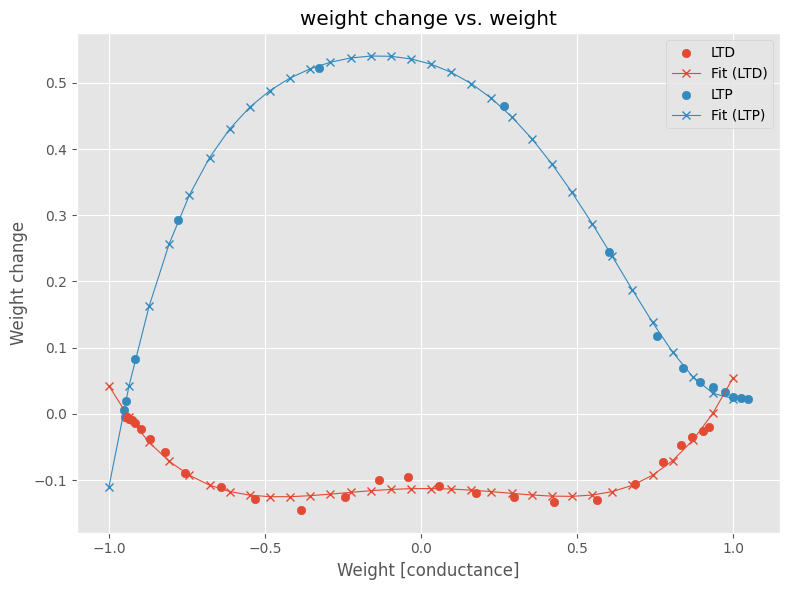

In [12]:
from numpy.polynomial.polynomial import Polynomial
pulses_ltp = np.where(pulses == 1)[0]
pulses_ltd = np.where(pulses == -1)[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pulses_ltd, conductance_ltd, label='Conductance (LTD)', marker='o')
ax.plot(pulses_ltp, conductance_ltp, label='Conductance (LTP)', marker='o')
# ax.plot(conductance)
ax.plot(np.gradient(conductance), label='Gradient')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Weight [conductance]", title="Weight vs. pulse number")
ax.legend()
plt.tight_layout()
#plt.savefig('tmp1.png')
plt.show()

grad_ltd = np.gradient(conductance_ltd)
grad_ltp = np.gradient(conductance_ltp)

fit_degree = 5
fit_grad_ltd = Polynomial.fit(conductance_ltd, grad_ltd, fit_degree)
fit_grad_ltp = Polynomial.fit(conductance_ltp, grad_ltp, fit_degree)

#xvals = np.linspace(conductance.min(), conductance.max(), 100)
xvals = np.linspace(-1, 1, 32)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(conductance_ltd, grad_ltd, label='LTD', color='C0')
ax.plot(xvals, fit_grad_ltd(xvals), label='Fit (LTD)', color='C0', lw=0.8, marker='x')

ax.scatter(conductance_ltp, grad_ltp, label='LTP', color='C1')
ax.plot(xvals, fit_grad_ltp(xvals), label='Fit (LTP)', color='C1', lw=0.8, marker='x')

ax.set(xlabel="Weight [conductance]", ylabel="Weight change", title="Weight change vs. weight")
ax.legend()
plt.tight_layout()
# plt.savefig('tmp2.png')
plt.show()

PiecewiseStepDevice(
    dw_min=0.2211927866349357,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=-0.1601889250740075,
    up_down_dtod=0.0,
    w_max=1.0156687531769806,
    w_max_dtod=0.0,
    w_min=-0.9983057605047843,
    w_min_dtod=0.0,
    piecewise_up=[
        0.500795102964819,
        0.19023149808922696,
        0.7358317610620138,
        1.1628922630034206,
        1.4944731654830743,
        1.7500810019096407,
        1.9459414648501154,
        2.095272193349111,
        2.20855556024815,
        2.2938114595049557,
        2.3568700935127382,
        2.401644760419492,
        2.4304046414472777,
        2.44404758821152,
        2.442372910040292,
        2.4243541612936093,
        2.3884119286827192,
        2.33268661858939,
        2.255311244385203,
        2.1546842137508406,
        2.029742115995379,
        1.8802325093755763,
        1.706986708415164,
        1.512192571224138,
        1.2996672868180474,
        1.075130162437285,

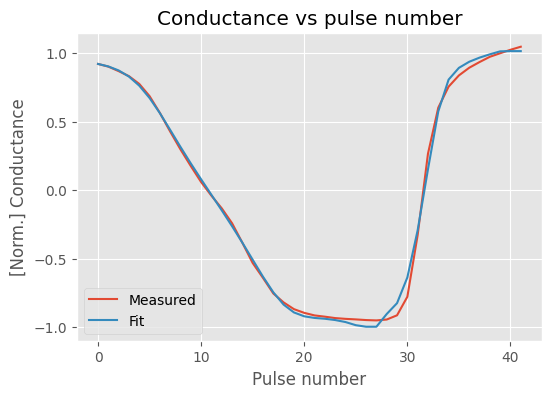

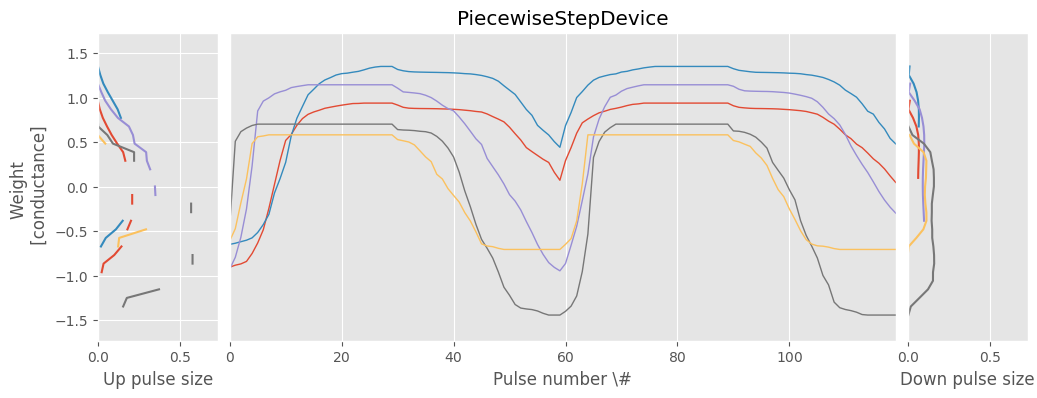

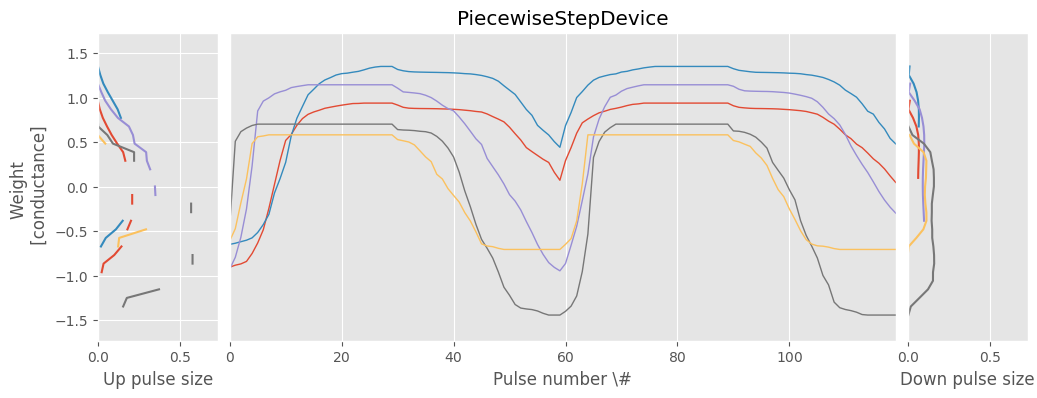

In [8]:
from aihwkit.utils.visualization import get_tile_for_plotting, compute_pulse_response
from aihwkit.simulator.configs import build_config
from aihwkit.utils.fitting import fit_measurements
from aihwkit.simulator.configs import PiecewiseStepDevice
from aihwkit.utils.visualization import plot_device_compact

condvals = np.linspace(-1, 1, 32)
fit_ltp_vals = np.abs(fit_grad_ltp(condvals))
fit_ltd_vals = np.abs(fit_grad_ltd(condvals))

params = {'dw_min': (0.1, 0.001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, pw_device_fit, pw_device_response = fit_measurements(
    params,
    pulses,
    conductance,
    PiecewiseStepDevice(
        piecewise_up=list(fit_ltp_vals),
        piecewise_down=list(fit_ltd_vals)
    ))

# rescale dw_min and conductance gradient
scale = (np.mean(fit_ltp_vals) + np.mean(fit_ltd_vals)) / 2
pw_device_fit.dw_min *= scale
pw_device_fit.piecewise_up = list(fit_ltp_vals / scale)
pw_device_fit.piecewise_down = list(fit_ltd_vals / scale)

print(pw_device_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(pw_device_response, label='Fit')
ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title="Conductance vs pulse number")
ax.legend()
plt.show()

pw_device_fit.dw_min_dtod = 0.3
pw_device_fit.dw_min_std = 0.3
pw_device_fit.w_min_dtod = 0.3
pw_device_fit.w_max_dtod = 0.3
pw_device_fit.write_noise_std = 0

rpu_config = build_config('sgd', pw_device_fit)
plot_device_compact(pw_device_fit, n_steps=30, n_traces=5, n_loops=2)